VAE with disentanglement

In [50]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

batchsize = 128
epochs=10
loginterval=10
cuda = torch.cuda.is_available()

SEED = 1
torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

In [51]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(20, 400),nn.ReLU(), nn.Linear(400, 784))
        
        
        self.fc = nn.Linear(784, 400)
        self.fcmu = nn.Linear(400, 20)
        self.fcvar = nn.Linear(400, 20)


        # create using nn.Sequential()
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)

        # and without using nn.Sequential, an encoder
        #FC (784 -> 400), RELU activation
        # then in parallel a FC (400, 20) for each mu / logvar

    def encode(self, x):
        z = F.relu(self.fc(x))
        mu = self.fcmu(z)
        logvar = self.fcvar(z)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # sample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [73]:
def loss_function(recon_batch, x, mu, logvar, beta):
    # compute binary cross entropy summed across the batch
    bce = nn.BCELoss(size_average=False)

    
    #   Kullback-Leibler divergence losses summed over all elements and batch
    kld = -0.5*torch.sum(1+ logvar-mu.pow(2)-logvar.exp())
    
    # the beta factor allows disentanglement for values >>1
    return bce(recon_batch,x)+kld*beta

In [74]:
losses = []
def train(epoch, beta):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar, beta)
        losses.append(loss.cpu().item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
         train_loss / len(train_loader.dataset)), end='')

In [75]:
def test(epoch, beta):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data.view(-1, 784), mu, logvar,beta)

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [79]:
beta = 0
for epoch in range(1, epochs + 1):
    train(epoch, beta)
    test(epoch, beta)
    with torch.no_grad():
         sample = torch.randn(64, 20).to(device)
         sample = model.decode(sample).cpu()
         save_image(sample.view(64, 1, 28, 28), 'results/sample_' + str(epoch) + '.png')    

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 103.7 Average loss: 113.0 Test loss: 98.1
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 86.9 Average loss: 91.4 Test loss: 84.6
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 80.1 Average loss: 82.3 Test loss: 78.6
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 78.6 Average loss: 77.6 Test loss: 75.1
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 70.2 Average loss: 74.5 Test loss: 72.6
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 71.8 Average loss: 72.4 Test loss: 71.1
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 70.1 Average loss: 71.0 Test loss: 70.1
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 69.9 Average loss: 70.0 Test loss: 69.3
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 70.6 Average loss: 69.2 Test loss: 68.7
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 69.3 Average loss: 68.6 Test loss: 68.2


In [7]:
 sample = torch.empty(64, 20)

# create a batch of 8x8 inputs sampled from normal distribution
# observe the image with different values of beta (0, 1, 10, 100)

save_image(sample.view(64, 1, 28, 28), 'results/sample_continuous.png')

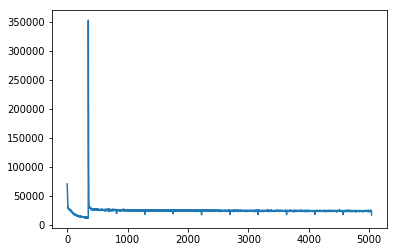

In [78]:
# plot losses
plt.plot(losses)

In [ ]:
#plot the gradient mean value for each FC layer across training
plt.plot(gradients)